# House Prices Prediction (Top 16.5%)
* **Exploratory Data Analysis**
* **Feature Engineering**
* **Machine Learning**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics

# 1. Overview
## 1.1 Load the data

In [2]:
path = os.getcwd()

In [3]:
train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')
train.head()
test.head()
print('train data size : {} and test data size: {}'.format(train.shape, test.shape))

train data size : (1460, 81) and test data size: (1459, 80)


## 1.2 Save the Id and Drop 'Id' columns

In [4]:
train_id = train['Id']
test_id = test['Id']
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

In [5]:
# combine train and test data for features engineering
ntrain = train.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.shape

(2919, 80)

## 1.3 Transform some numerical features to categorical features

In [6]:
# MSSubClass is an int64 type, but it represents the building class of the house. so the feature is categorical
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

#MoSold, GarageYrBlt, YearBuilt, YearRemodAdd and YrSold are also categorical features with int64 type, but they are ordinal.
#No need to change their dtypes.

## 1.4 Heatmap

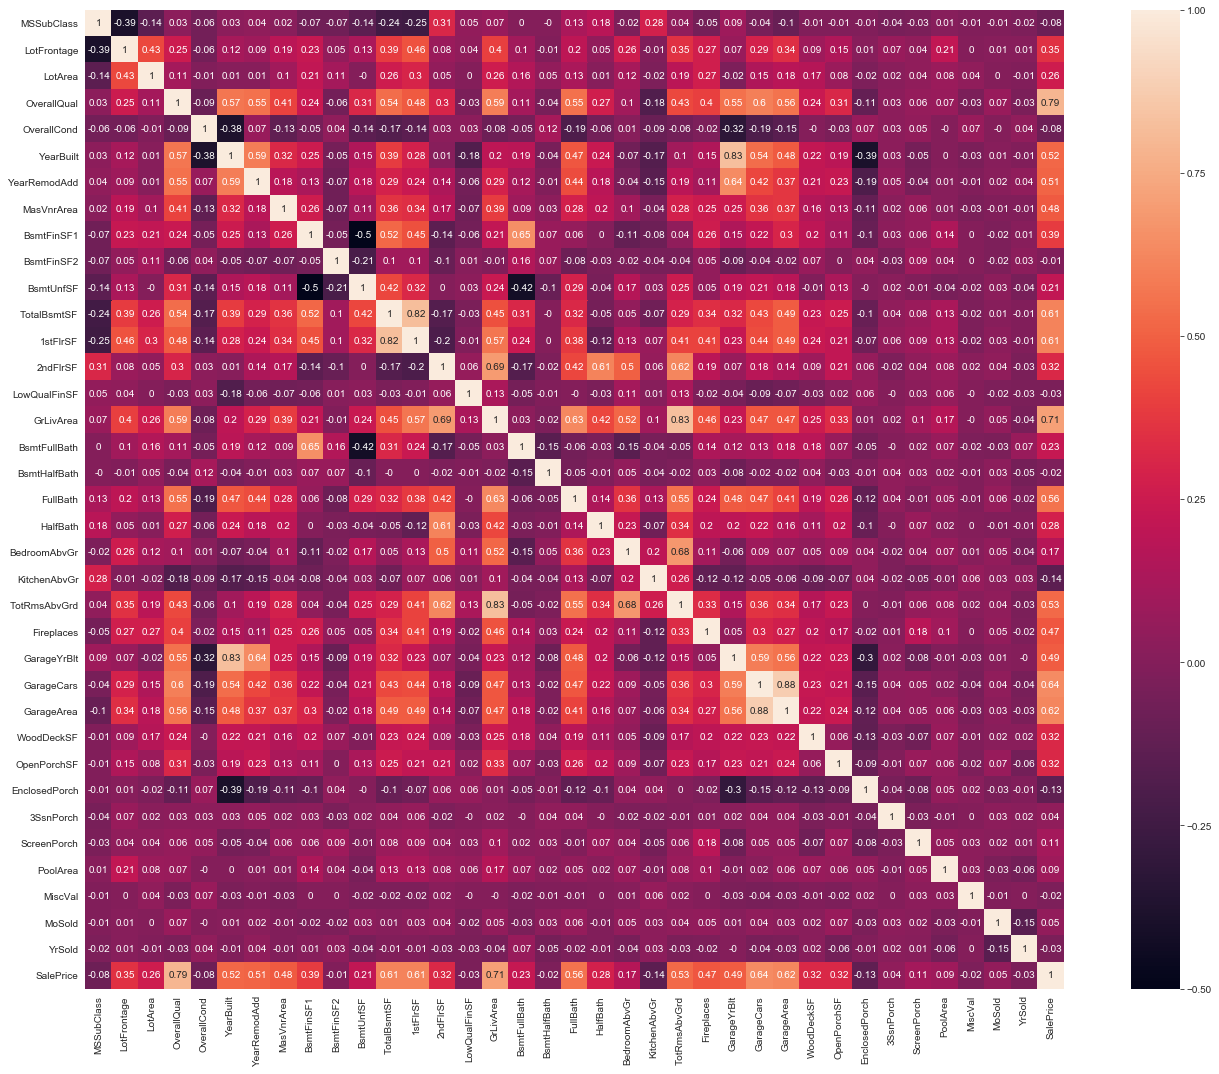

In [7]:
corrmat = train.corr()
plt.subplots(figsize=(24,18))
sns.heatmap(corrmat.round(2), annot=True, square=True)

## 1.5 Correlations: Features VS Target

In [8]:
num_features = [feature for feature in all_data.columns if all_data[feature].dtype != 'object']
cat_features = [feature for feature in all_data.columns if all_data[feature].dtype == 'object']

print(len(num_features), len(cat_features))

36 44


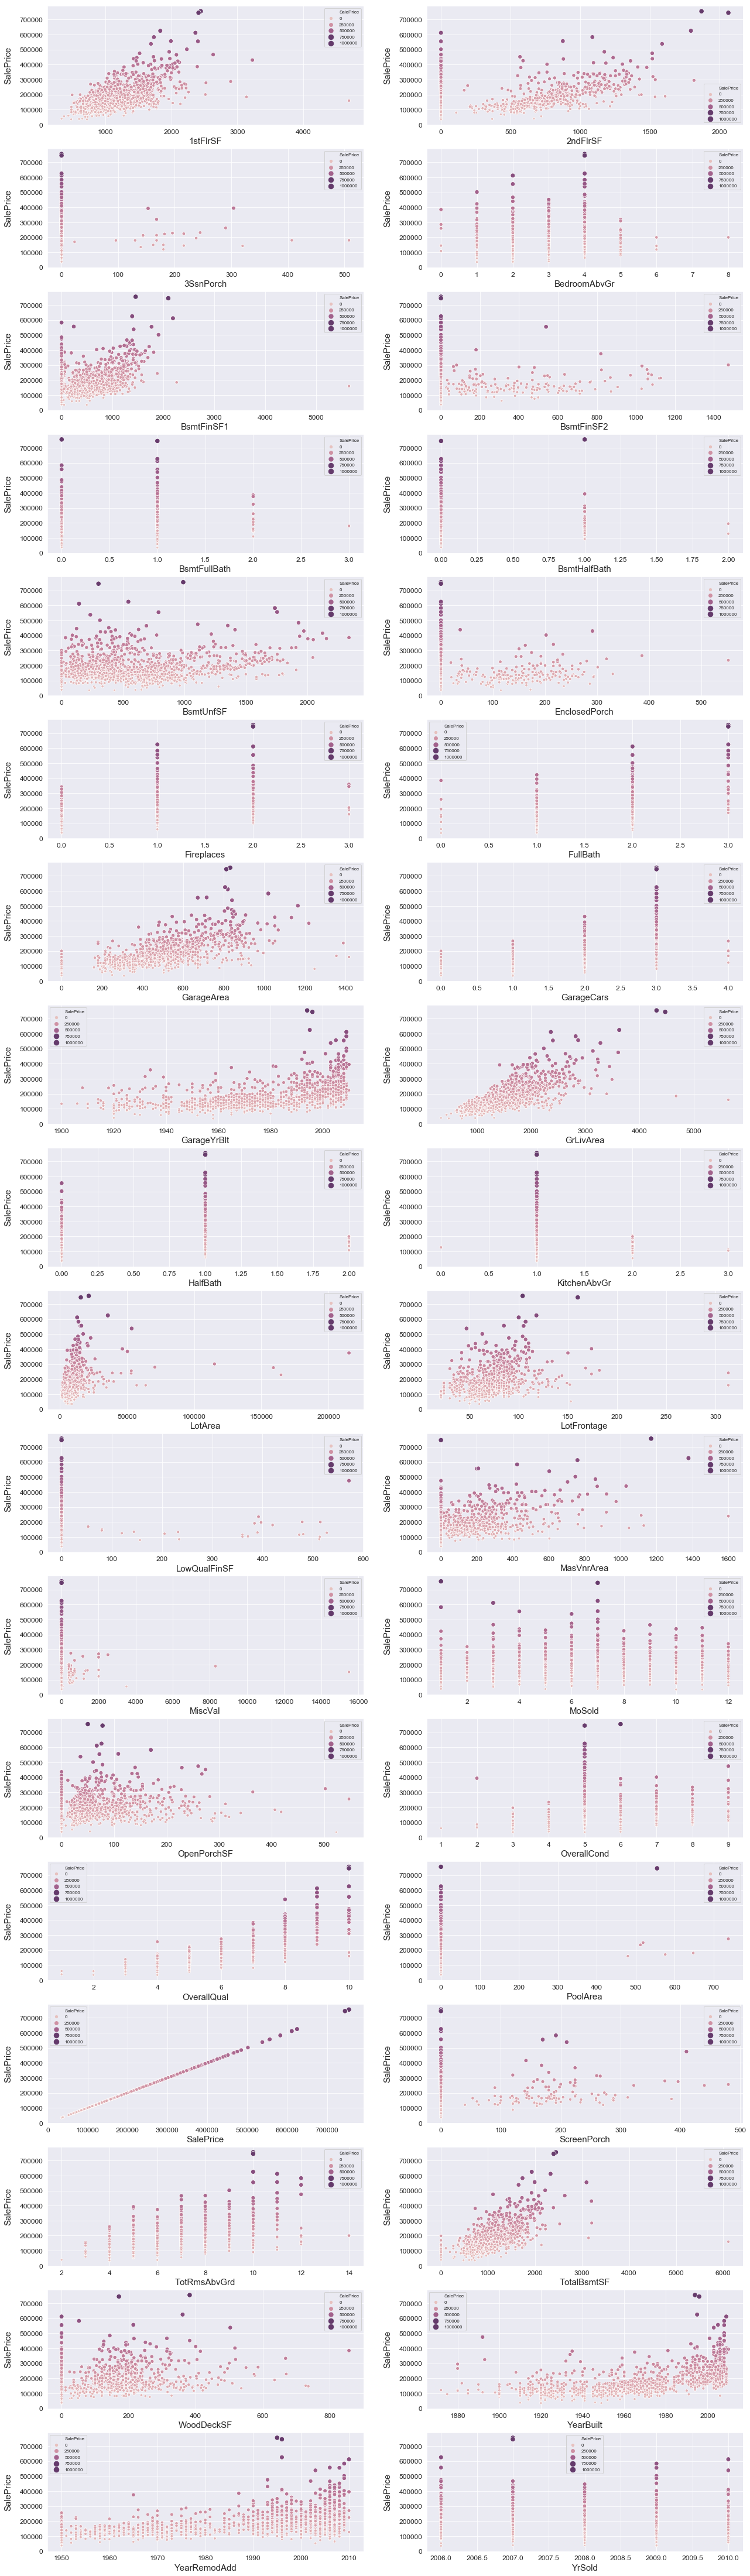

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=18, figsize=(12, 80))
plt.subplots_adjust(right=1.5)
cmap = sns.cubehelix_palette(dark=0.3, light=0.8, as_cmap=True)

for i, feature in enumerate(num_features, 1):    
    plt.subplot(18, 2, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', size='SalePrice', palette=cmap, data=train)
        
    plt.xlabel('{}'.format(feature), size=15)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 8})
        
plt.show()

In [10]:
#Remove Outliers
all_data = all_data.drop(all_data[(all_data['GrLivArea']>4000) & (all_data['SalePrice']<300000)].index)
all_data = all_data.drop(all_data[(all_data['1stFlrSF']>4000) & (all_data['SalePrice']<300000)].index)
all_data = all_data.drop(all_data[(all_data['BsmtFinSF1']>4000) & (all_data['SalePrice']<300000)].index)
all_data = all_data.drop(all_data[(all_data['LotFrontage']>250) & (all_data['SalePrice']<300000)].index)
all_data = all_data.drop(all_data[(all_data['TotalBsmtSF']>6000) & (all_data['SalePrice']<300000)].index)
all_data.shape

(2916, 80)

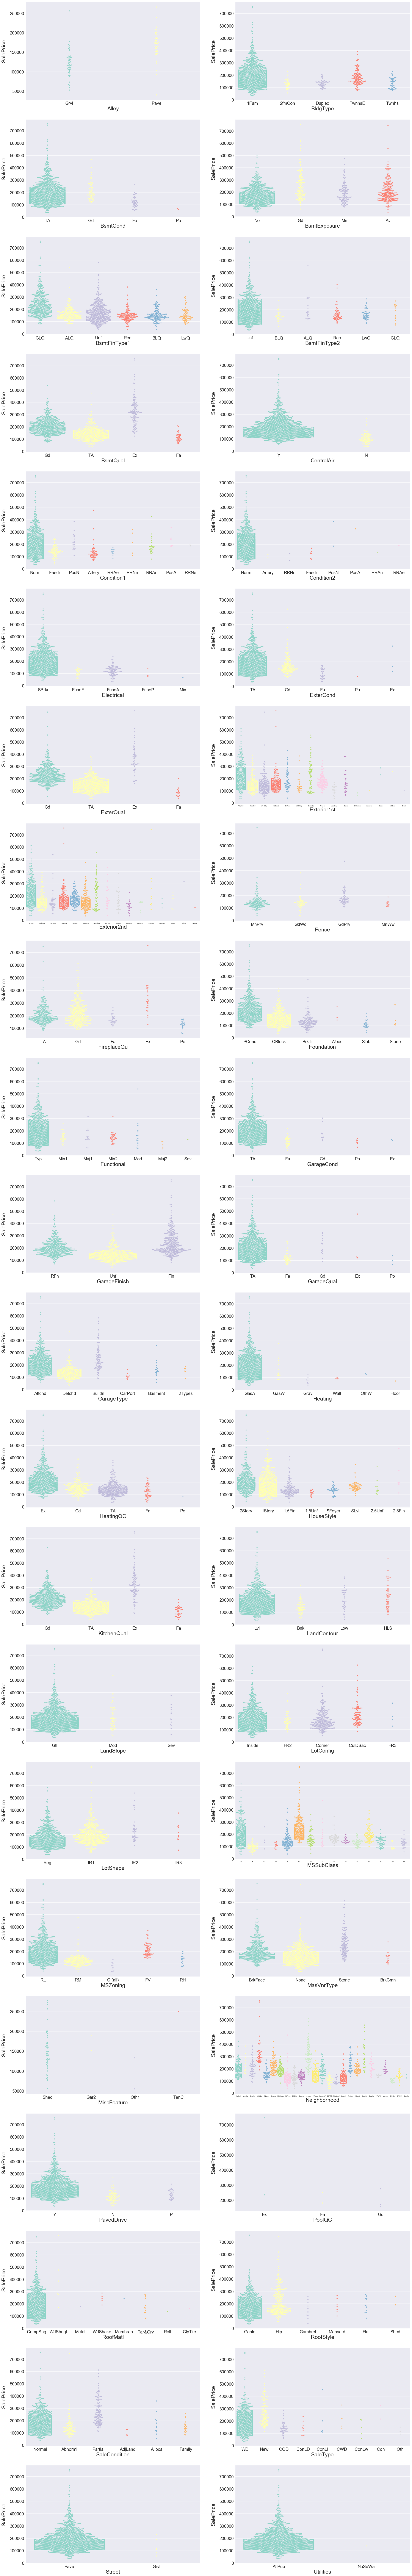

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=22, figsize=(18, 120))
plt.subplots_adjust(right=1.5, top=1.5)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(22, 2, i)
    sns.swarmplot(x=feature, y='SalePrice', data=train, palette='Set3')
        
    plt.xlabel('{}'.format(feature), size=25)
    plt.ylabel('SalePrice', size=25, labelpad=15)
    
    for j in range(2):
        if train[feature].value_counts().shape[0] > 10:        
            plt.tick_params(axis='x', labelsize=7)
        else:
            plt.tick_params(axis='x', labelsize=20)
        plt.tick_params(axis='y', labelsize=20)
            
plt.show()

In [12]:
#**Drop useless features**
print(all_data.Utilities.value_counts())
print(all_data.Street.value_counts())

AllPub    2913
NoSeWa       1
Name: Utilities, dtype: int64
Pave    2904
Grvl      12
Name: Street, dtype: int64


In [13]:
#So it's safe to drop these two features
all_data.drop(['Utilities','Street'], axis = 1, inplace = True)

# 2. Data Processing 
## 2.1 analysis the Target Variable 'SalePrice'

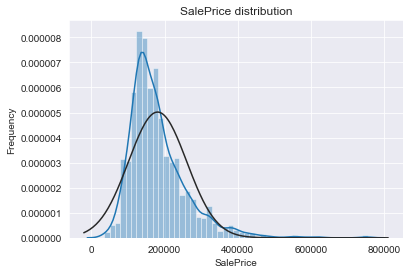

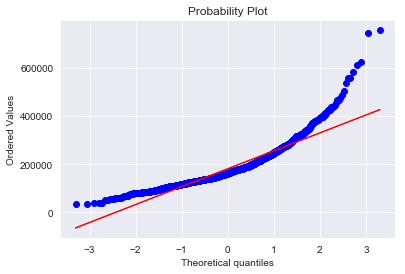

In [14]:
sns.distplot(all_data['SalePrice'].dropna() , fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['SalePrice'].dropna(), plot=plt)
plt.show()

## 2.2 Transform this variable and make it more normally distributed.

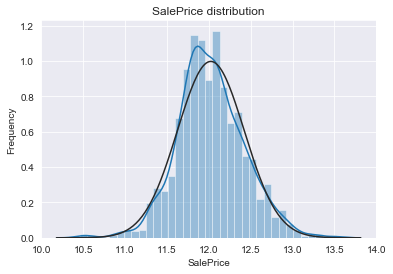

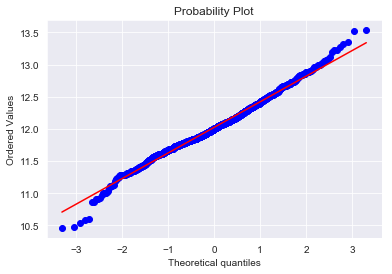

In [15]:
all_data["SalePrice"] = np.log1p(all_data["SalePrice"])

# re-plot previous figures
sns.distplot(all_data['SalePrice'].dropna() , fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['SalePrice'].dropna(), plot=plt)
plt.show()

## 2.3 Handle missing values

In [16]:
y_train = all_data.SalePrice.dropna()
all_data.drop(['SalePrice'], axis = 1, inplace = True)

In [17]:
len(y_train)

1457

In [18]:
all_data_na = (all_data.isnull().sum())
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
all_data_na

PoolQC          2907
MiscFeature     2811
Alley           2718
Fence           2345
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
SaleType           1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
GarageCars         1
KitchenQual        1
TotalBsmtSF        1
dtype: int64

In [19]:
# As the description text indicates, NA means 'No' for those features mentioned below
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")

In [20]:
for col in ('Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual','MasVnrType','MSSubClass',
            'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','MasVnrArea',
            'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [21]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [22]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [23]:
# for functional and electrical etc., using the most common values to fillna
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [24]:
#check again
all_data_na = all_data.isnull().sum()
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
all_data_na

Series([], dtype: int64)

## 2.4 Label Encoding some categorical variables that may contain information in their ordering set

In [25]:
cat_features = [feature for feature in all_data.columns if all_data[feature].dtype == 'object' and all_data[feature].nunique() <= 5]
cat_features.append('MoSold')
cat_features

['Alley',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtQual',
 'CentralAir',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Fence',
 'GarageFinish',
 'HeatingQC',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'PavedDrive',
 'PoolQC',
 'MoSold']

In [26]:
from sklearn.preprocessing import LabelEncoder

for c in cat_features:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [27]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## 2.5 Skewed features

In [28]:
num_features = [feature for feature in all_data.columns if all_data[feature].dtype != 'object']
skewed_features = all_data[num_features].apply(lambda x: skew(x)).sort_values(ascending = False)
skewed_features

MiscVal          21.935910
PoolArea         17.685603
LotArea          13.139681
LowQualFinSF     12.082427
3SsnPorch        11.370087
MiscFeature       5.061421
LandSlope         4.994554
KitchenAbvGr      4.299698
BsmtFinSF2        4.143683
EnclosedPorch     4.001570
ScreenPorch       3.944305
BsmtHalfBath      3.929197
MasVnrArea        2.621183
OpenPorchSF       2.528966
BldgType          2.190511
WoodDeckSF        1.844373
1stFlrSF          1.258583
GrLivArea         1.069955
TotalSF           1.009140
BsmtFinSF1        0.980445
BsmtUnfSF         0.919245
2ndFlrSF          0.861039
TotRmsAbvGrd      0.750319
Fireplaces        0.725860
HalfBath          0.696122
TotalBsmtSF       0.671361
LotFrontage       0.637458
BsmtFullBath      0.623366
OverallCond       0.570295
HeatingQC         0.484973
BedroomAbvGr      0.327348
GarageArea        0.216978
MoSold            0.197558
OverallQual       0.190174
FullBath          0.166179
YrSold            0.132135
MasVnrType       -0.071931
G

In [29]:
# Box Cox Transformation of skewed features
skewness = skewed_features[abs(skewed_features) > 0.75]

from scipy.special import boxcox1p
skewed_index = skewness.index
lam = 0.15
for feat in skewed_index:
    all_data[feat] = boxcox1p(all_data[feat], lam)

## 2.6 Getting dummy categorical features

In [30]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2916, 241)

In [31]:
train = all_data[:len(y_train)]
test = all_data[len(y_train):]

# 3. Modeling

In [32]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

## 3.1 Cost Functions & Cross Validation

In [33]:
def rmse(y_train, y_pred):
     return np.sqrt(mean_squared_error(y_train, y_pred))

def cv_rmse(model, X=train, y=y_train):    
    return np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))

K = 5    
kf = KFold(n_splits=K, shuffle=True, random_state=1)

## 3.2 Models & Stacking

In [34]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=np.arange(14.5, 15.6, 0.1), cv=kf))
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=np.arange(0.0001, 0.0009, 0.0001), random_state=35, cv=kf))
ENet = make_pipeline(RobustScaler(), ElasticNetCV(alphas=np.arange(0.0001, 0.0008, 0.0001), l1_ratio=np.arange(0.8, 1, 0.025), cv=kf))

model_xgb = xgb.XGBRegressor(learning_rate=0.01,
                            n_estimators=3500,max_depth=3,
                            gamma=0.001,subsample=0.7,
                            colsample_bytree=0.7,objective='reg:squarederror',
                            nthread=-1,seed=41,reg_alpha=0.0001)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

stack = StackingCVRegressor(regressors=(lasso, ENet, ridge, model_lgb), meta_regressor=model_lgb, use_features_in_secondary=True)

In [35]:
models = {'RidgeCV': ridge,
          'LassoCV': lasso, 
          'ElasticNetCV': ENet, 
          'LightGBMRegressor': model_lgb, 
          'XGBoostRegressor': model_xgb, 
         'StackingCVRegressor': stack}
scores = {}

for name, model in models.items():
    
    model.fit(train, y_train)
    
    score = cv_rmse(model, X=train, y=y_train)
    scores[name] = (score.mean(), score.std())
    
    
    print('{} Mean RMSE: {:.6f} / Std: {:.6f}\n'.format(name, scores[name][0], scores[name][1]))

RidgeCV Mean RMSE: 0.111440 / Std: 0.006971

LassoCV Mean RMSE: 0.112070 / Std: 0.006526

ElasticNetCV Mean RMSE: 0.112001 / Std: 0.006441

LightGBMRegressor Mean RMSE: 0.114593 / Std: 0.005924

XGBoostRegressor Mean RMSE: 0.112999 / Std: 0.007816

StackingCVRegressor Mean RMSE: 0.112965 / Std: 0.005221



In [36]:
def blend_predict(X):
    return ((0.25 * ENet.predict(X)) + 
            (0.25 * ridge.predict(X))+
            (0.1 * lasso.predict(X)) +
            (0.1 * model_xgb.predict(X)) +
            (0.1 * model_lgb.predict(X)) +
            (0.2 * stack.predict(X)))

blended_score = rmse(y_train, blend_predict(train))
print('Blended Prediction RMSE: {}'.format(blended_score))

Blended Prediction RMSE: 0.08301370888927401


## 3.3 Submission

In [37]:
submission_df = pd.DataFrame(columns=['Id', 'SalePrice'])
submission_df['Id'] = test_id
submission_df['SalePrice'] = np.expm1(blend_predict(test))
submission_df.to_csv('sub.csv', header=True, index=False)